Sheets found: ['Sheet1']
Columns: ['Date', 'Carrier', 'Service_Type', 'Departures', 'Passengers', '%_of_2019', 'Month', 'Year', 'Week_Number', 'Weather_Score', 'Fuel_Price', 'Holiday_Flag']
Rows: 553
        Date      Carrier Service_Type  Departures  Passengers  %_of_2019  \
0 2023-07-03  Academy Bus     Commuter        2508       89222      111.5   
1 2023-07-03    Coach USA     Commuter        2911      103516      115.0   
2 2023-07-03    ShortLine     Commuter        2104       82840      118.3   
3 2023-07-03    Greyhound    Intercity        2115       75953      108.5   
4 2023-07-03      Megabus    Intercity        1665       52761       87.9   

  Month  Year  Week_Number  Weather_Score  Fuel_Price  Holiday_Flag  
0  July  2023           27            8.4        3.45             1  
1  July  2023           27            8.6        3.40             1  
2  July  2023           27            8.2        3.41             1  
3  July  2023           27            7.8        3.46    

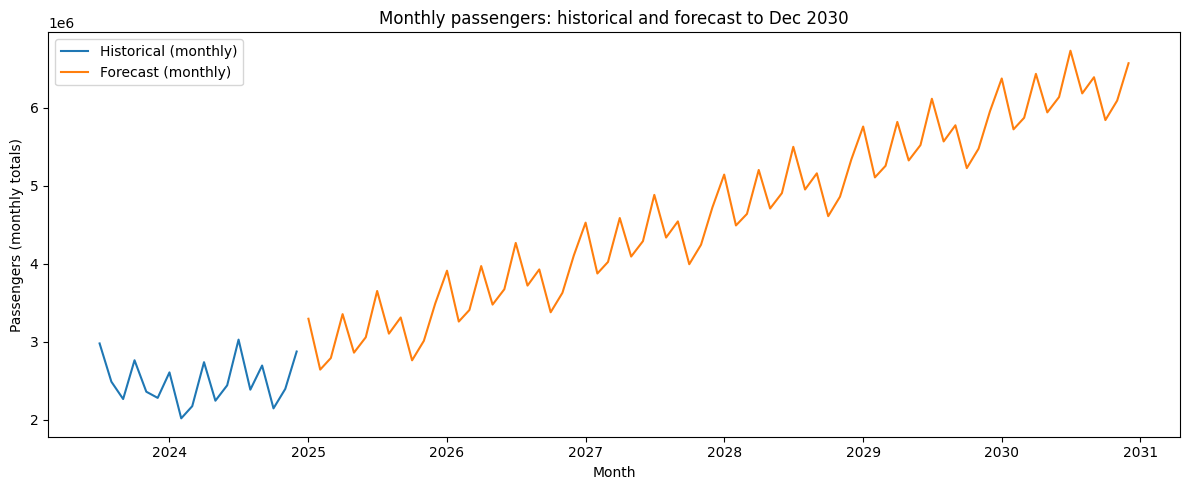

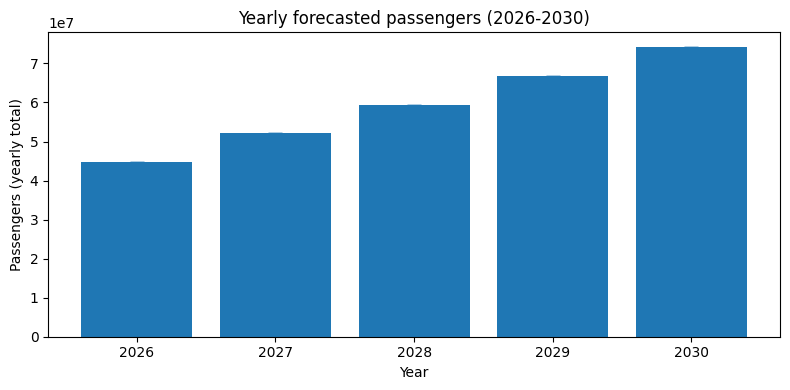

Plots saved: monthly_forecast_plot.png and yearly_forecast_plot.png


In [4]:
#!/usr/bin/env python3
# forecast_passengers_2026_2030.py
# Baseline pipeline: loads Excel -> monthly aggregation -> SARIMAX forecast -> save plots/tables

from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.simplefilter('ignore')

# ---- CONFIG ----
INPUT_XLSX = 'Final_Passenger_Data.xlsx'   # change path if needed
SHEET_TO_USE = 0  # index or name of the sheet to use
OUTPUT_YEARLY_CSV = './passenger_forecast_2026_2030.csv'
# ----------------

# 1) Load file and inspect
xlsx = pd.ExcelFile(INPUT_XLSX)
print("Sheets found:", xlsx.sheet_names)
df = pd.read_excel(INPUT_XLSX, sheet_name=SHEET_TO_USE)
print("Columns:", df.columns.tolist())
print("Rows:", len(df))
print(df.head(5))

# 2) Detect date column (best-effort)
date_candidates = [c for c in df.columns if 'date' in c.lower() or 'day' in c.lower() or 'time' in c.lower()]
parsed_date_col = None
for c in date_candidates:
    try:
        tmp = pd.to_datetime(df[c], errors='coerce')
        if tmp.notna().sum() > 0:
            parsed_date_col = c
            df[c] = tmp
            break
    except Exception:
        pass

if parsed_date_col is None:
    # try to infer any column that can be mostly parsed
    for c in df.columns:
        try:
            tmp = pd.to_datetime(df[c], errors='coerce')
            if tmp.notna().sum() > len(df) * 0.5 and tmp.notna().sum() > 10:
                parsed_date_col = c
                df[c] = tmp
                break
        except Exception:
            pass

if parsed_date_col is None:
    raise SystemExit("Couldn't detect a date column automatically. Please open the file and set `parsed_date_col` manually in the script.")

print("Using date column:", parsed_date_col)
df = df.rename(columns={parsed_date_col: 'date'})
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df = df.dropna(subset=['date'])

# 3) Detect passenger/count column (best-effort)
candidates = [c for c in df.columns if 'pass' in c.lower() or 'pax' in c.lower() or 'count' in c.lower() or 'num' in c.lower()]
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
for c in numeric_cols:
    if c not in candidates and df[c].min() >= 0 and df[c].mean() > 0 and df[c].nunique() > 3:
        candidates.append(c)

candidates = list(dict.fromkeys(candidates))
print("Passenger candidate columns:", candidates)

if len(candidates) == 0:
    raise SystemExit("No passenger-like columns detected. Edit the script to pick the correct column.")

# choose candidate with largest sum
sums = {c: df[c].fillna(0).sum() if np.issubdtype(df[c].dtype, np.number) else -1 for c in candidates}
passenger_col = max(sums, key=sums.get)
print("Chosen passenger column:", passenger_col, "with total:", sums[passenger_col])

df[passenger_col] = pd.to_numeric(df[passenger_col], errors='coerce').fillna(0)

# 4) Aggregate to monthly totals
df['month_start'] = df['date'].dt.to_period('M').dt.to_timestamp()
monthly = df.groupby('month_start')[passenger_col].sum().reset_index().rename(columns={'month_start':'ds', passenger_col:'y'})
monthly = monthly.sort_values('ds').set_index('ds')

# Fill missing months with zeros (or could forward-fill)
all_months = pd.date_range(monthly.index.min(), monthly.index.max(), freq='MS')
monthly = monthly.reindex(all_months).fillna(0)
monthly.index.name = 'ds'
print("Monthly series from", monthly.index.min().date(), "to", monthly.index.max().date(), "(", len(monthly), "months )")

# 5) Train / test split (last 12 months for quick validation)
if len(monthly) < 24:
    print("Warning: less than 24 months of data; forecasting may be unreliable.")
train = monthly.iloc[:-12]
test = monthly.iloc[-12:]

# 6) Fit SARIMAX baseline (seasonal monthly=12)
order = (1,1,1)
seasonal_order = (0,1,1,12)
model = SARIMAX(train['y'], order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
res = model.fit(disp=False)

# 7) Validate on test
pred_test = res.get_forecast(steps=len(test))
pred_mean = pred_test.predicted_mean
pred_ci = pred_test.conf_int(alpha=0.05)

mae = mean_absolute_error(test['y'], pred_mean)
rmse = mean_squared_error(test['y'], pred_mean) #squared=False
mape = (np.abs((test['y'] - pred_mean) / (test['y'] + 1e-9))).mean() * 100
print(f"Validation on last {len(test)} months: MAE={mae:.1f}, RMSE={rmse:.1f}, MAPE={mape:.2f}%")

# 8) Refit on full data and forecast to Dec 2030
res_full = SARIMAX(monthly['y'], order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False).fit(disp=False)
start_fore = monthly.index.max() + pd.offsets.MonthBegin(1)
end_fore = pd.Timestamp('2030-12-01')
future_months = pd.date_range(start_fore, end_fore, freq='MS')
steps = len(future_months)

fcast = res_full.get_forecast(steps=steps)
fcast_mean = fcast.predicted_mean
fcast_ci = fcast.conf_int(alpha=0.05)

forecast_monthly = pd.DataFrame({
    'ds': future_months,
    'yhat': fcast_mean.values,
    'yhat_lower': fcast_ci.iloc[:,0].values,
    'yhat_upper': fcast_ci.iloc[:,1].values
}).set_index('ds')

# 9) Yearly aggregation 2026-2030
forecast_monthly['year'] = forecast_monthly.index.year
yearly = forecast_monthly.groupby('year').agg({'yhat':'sum','yhat_lower':'sum','yhat_upper':'sum'}).loc[2026:2030].reset_index()
print("Yearly forecast 2026-2030:")
print(yearly)

# 10) Save CSV
yearly.to_csv(OUTPUT_YEARLY_CSV, index=False)
print("Saved yearly forecast to:", OUTPUT_YEARLY_CSV)

# 11) Plots
plt.figure(figsize=(12,5))
plt.plot(monthly.index, monthly['y'], label='Historical (monthly)')
plt.plot(forecast_monthly.index, forecast_monthly['yhat'], label='Forecast (monthly)')
plt.fill_between(forecast_monthly.index, forecast_monthly['yhat_lower'], forecast_monthly['yhat_upper'], alpha=0.2)
plt.title("Monthly passengers: historical and forecast to Dec 2030")
plt.xlabel("Month")
plt.ylabel("Passengers (monthly totals)")
plt.legend()
plt.tight_layout()
plt.savefig('monthly_forecast_plot.png')
plt.show()

plt.figure(figsize=(8,4))
plt.bar(yearly['year'].astype(str), yearly['yhat'])
plt.errorbar(yearly['year'].astype(str), yearly['yhat'],
             yerr=[yearly['yhat'] - yearly['yhat_lower'], yearly['yhat_upper'] - yearly['yhat']],
             fmt='none', capsize=5)
plt.title("Yearly forecasted passengers (2026-2030)")
plt.xlabel("Year")
plt.ylabel("Passengers (yearly total)")
plt.tight_layout()
plt.savefig('yearly_forecast_plot.png')
plt.show()

print("Plots saved: monthly_forecast_plot.png and yearly_forecast_plot.png")
